In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container {width:100% !important;}<style>"))

# CRFasRNN

In [4]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import numpy as np
import tensorflow as tf
from keras.models import Model
from keras import layers
from keras.layers import Conv2D, Conv2DTranspose, Cropping2D, DepthwiseConv2D
from keras.layers import ZeroPadding2D, AveragePooling2D, ZeroPadding2D,MaxPooling2D
from keras.layers import Input, Activation, Concatenate, Add, Lambda, Dropout, BatchNormalization
from keras.engine import Layer, InputSpec
from keras.engine.topology import get_source_inputs
from keras.optimizers import Adam
from keras.utils import conv_utils, multi_gpu_model
from keras.applications import imagenet_utils
from keras import backend as K
from crfrnn_layer import CrfRnnLayer
DATA_SHAPE = 224

Using TensorFlow backend.


In [5]:
class BilinearUpsampling(Layer):
    """Just a simple bilinear upsampling layer. Works only with TF.
       Args:
           upsampling: tuple of 2 numbers > 0. The upsampling ratio for h and w
           output_size: used instead of upsampling arg if passed!
    """

    def __init__(self, upsampling=(2, 2), output_size=None, data_format=None, **kwargs):

        super(BilinearUpsampling, self).__init__(**kwargs)

        self.data_format = conv_utils.normalize_data_format(data_format)
        self.input_spec = InputSpec(ndim=4)
        if output_size:
            self.output_size = conv_utils.normalize_tuple(
                output_size, 2, 'output_size')
            self.upsampling = None
        else:
            self.output_size = None
            self.upsampling = conv_utils.normalize_tuple(
                upsampling, 2, 'upsampling')

    def compute_output_shape(self, input_shape):
        if self.upsampling:
            height = self.upsampling[0] * \
                input_shape[1] if input_shape[1] is not None else None
            width = self.upsampling[1] * \
                input_shape[2] if input_shape[2] is not None else None
        else:
            height = self.output_size[0]
            width = self.output_size[1]
        return (input_shape[0],
                height,
                width,
                input_shape[3])

    def call(self, inputs):
        if self.upsampling:
            return K.tf.image.resize_bilinear(inputs, (inputs.shape[1] * self.upsampling[0],
                                                       inputs.shape[2] * self.upsampling[1]),
                                              align_corners=True)
        else:
            return K.tf.image.resize_bilinear(inputs, (self.output_size[0],
                                                       self.output_size[1]),
                                              align_corners=True)

    def get_config(self):
        config = {'upsampling': self.upsampling,
                  'output_size': self.output_size,
                  'data_format': self.data_format}
        base_config = super(BilinearUpsampling, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))

In [6]:
def SepConv_BN(x, filters, prefix, stride=1, kernel_size=3, rate=1, depth_activation=False, epsilon=1e-3):
    """ SepConv with BN between depthwise & pointwise. Optionally add activation after BN
        Implements right "same" padding for even kernel sizes
        Args:
            x: input tensor
            filters: num of filters in pointwise convolution
            prefix: prefix before name
            stride: stride at depthwise conv
            kernel_size: kernel size for depthwise convolution
            rate: atrous rate for depthwise convolution
            depth_activation: flag to use activation between depthwise & poinwise convs
            epsilon: epsilon to use in BN layer
    """

    if stride == 1:
        depth_padding = 'same'
    else:
        kernel_size_effective = kernel_size + (kernel_size - 1) * (rate - 1)
        pad_total = kernel_size_effective - 1
        pad_beg = pad_total // 2
        pad_end = pad_total - pad_beg
        x = ZeroPadding2D((pad_beg, pad_end))(x)
        depth_padding = 'valid'

    if not depth_activation:
        x = Activation('relu')(x)
    x = DepthwiseConv2D((kernel_size, kernel_size), strides=(stride, stride), dilation_rate=(rate, rate),
                        padding=depth_padding, use_bias=False, name=prefix + '_depthwise')(x)
    x = BatchNormalization(name=prefix + '_depthwise_BN', epsilon=epsilon)(x)
    if depth_activation:
        x = Activation('relu')(x)
    x = Conv2D(filters, (1, 1), padding='same',
               use_bias=False, name=prefix + '_pointwise')(x)
    x = BatchNormalization(name=prefix + '_pointwise_BN', epsilon=epsilon)(x)
    if depth_activation:
        x = Activation('relu')(x)

    return x

In [7]:
def _conv2d_same(x, filters, prefix, stride=1, kernel_size=3, rate=1):
    """Implements right 'same' padding for even kernel sizes
        Without this there is a 1 pixel drift when stride = 2
        Args:
            x: input tensor
            filters: num of filters in pointwise convolution
            prefix: prefix before name
            stride: stride at depthwise conv
            kernel_size: kernel size for depthwise convolution
            rate: atrous rate for depthwise convolution
    """
    if stride == 1:
        return Conv2D(filters,
                      (kernel_size, kernel_size),
                      strides=(stride, stride),
                      padding='same', use_bias=False,
                      dilation_rate=(rate, rate),
                      name=prefix)(x)
    else:
        kernel_size_effective = kernel_size + (kernel_size - 1) * (rate - 1)
        pad_total = kernel_size_effective - 1
        pad_beg = pad_total // 2
        pad_end = pad_total - pad_beg
        x = ZeroPadding2D((pad_beg, pad_end))(x)
        return Conv2D(filters,
                      (kernel_size, kernel_size),
                      strides=(stride, stride),
                      padding='valid', use_bias=False,
                      dilation_rate=(rate, rate),
                      name=prefix)(x)

In [8]:
def _xception_block(inputs, depth_list, prefix, skip_connection_type, stride,
                    rate=1, depth_activation=False, return_skip=False):
    """ Basic building block of modified Xception network
        Args:
            inputs: input tensor
            depth_list: number of filters in each SepConv layer. len(depth_list) == 3
            prefix: prefix before name
            skip_connection_type: one of {'conv','sum','none'}
            stride: stride at last depthwise conv
            rate: atrous rate for depthwise convolution
            depth_activation: flag to use activation between depthwise & pointwise convs
            return_skip: flag to return additional tensor after 2 SepConvs for decoder
            """
    residual = inputs
    for i in range(3):
        residual = SepConv_BN(residual,
                              depth_list[i],
                              prefix + '_separable_conv{}'.format(i + 1),
                              stride=stride if i == 2 else 1,
                              rate=rate,
                              depth_activation=depth_activation)
        if i == 1:
            skip = residual
    if skip_connection_type == 'conv':
        shortcut = _conv2d_same(inputs, depth_list[-1], prefix + '_shortcut',
                                kernel_size=1,
                                stride=stride)
        shortcut = BatchNormalization(name=prefix + '_shortcut_BN')(shortcut)
        outputs = layers.add([residual, shortcut])
    elif skip_connection_type == 'sum':
        outputs = layers.add([residual, inputs])
    elif skip_connection_type == 'none':
        outputs = residual
    if return_skip:
        return outputs, skip
    else:
        return outputs
    
def relu6(x):
    return K.relu(x, max_value=6)

In [12]:
def deeplabv_crf(input_tensor=None, input_shape=(224, 224, 3), OS=16):
    """ Instantiates the Deeplabv3+ architecture

    Optionally loads weights pre-trained
    on PASCAL VOC. This model is available for TensorFlow only,
    and can only be used with inputs following the TensorFlow
    data format `(width, height, channels)`.
    # Arguments
        input_tensor: optional Keras tensor (i.e. output of `layers.Input()`)
            to use as image input for the model.
        input_shape: shape of input image. format HxWxC
            PASCAL VOC model was trained on (512,512,3) images
        OS: determines input_shape/feature_extractor_output ratio. One of {8,16}.
            Used only for xception backbone.

    # Returns
        A Keras model instance.

    # Raises
        RuntimeError: If attempting to run this model with a
            backend that does not support separable convolutions.
        ValueError: in case of invalid argument for `weights` or `backbone`

    """

    if input_tensor is None:
        img_input = Input(shape=input_shape)
    else:
        if not K.is_keras_tensor(input_tensor):
            img_input = Input(tensor=input_tensor, shape=input_shape)
        else:
            img_input = input_tensor

    if OS == 8:
        entry_block3_stride = 1
        middle_block_rate = 2  # ! Not mentioned in paper, but required
        exit_block_rates = (2, 4)
        atrous_rates = (12, 24, 36)
    else:
        entry_block3_stride = 2
        middle_block_rate = 1
        exit_block_rates = (1, 2)
        atrous_rates = (6, 12, 18)

    x = Conv2D(32, (3, 3), strides=(2, 2),
               name='entry_flow_conv1_1', use_bias=False, padding='same')(img_input)
    x = BatchNormalization(name='entry_flow_conv1_1_BN')(x)
    x = Activation('relu')(x)

    x = _conv2d_same(x, 64, 'entry_flow_conv1_2', kernel_size=3, stride=1)
    x = BatchNormalization(name='entry_flow_conv1_2_BN')(x)
    x = Activation('relu')(x)

    x = _xception_block(x, [128, 128, 128], 'entry_flow_block1',
                        skip_connection_type='conv', stride=2,
                        depth_activation=False)
    x, skip1 = _xception_block(x, [256, 256, 256], 'entry_flow_block2',
                               skip_connection_type='conv', stride=2,
                               depth_activation=False, return_skip=True)

    x = _xception_block(x, [728, 728, 728], 'entry_flow_block3',
                        skip_connection_type='conv', stride=entry_block3_stride,
                        depth_activation=False)
    for i in range(16):
        x = _xception_block(x, [728, 728, 728], 'middle_flow_unit_{}'.format(i + 1),
                            skip_connection_type='sum', stride=1, rate=middle_block_rate,
                            depth_activation=False)

    x = _xception_block(x, [728, 1024, 1024], 'exit_flow_block1',
                        skip_connection_type='conv', stride=1, rate=exit_block_rates[0],
                        depth_activation=False)
    x = _xception_block(x, [1536, 1536, 2048], 'exit_flow_block2',
                        skip_connection_type='none', stride=1, rate=exit_block_rates[1],
                        depth_activation=True)

    # end of feature extractor
    # branching for Atrous Spatial Pyramid Pooling
    # Image Feature branch
    #out_shape = int(np.ceil(input_shape[0] / OS))
    b4 = AveragePooling2D(pool_size=(int(np.ceil(input_shape[0] / OS)), 
                                     int(np.ceil(input_shape[1] / OS))))(x)
    b4 = Conv2D(256, (1, 1), padding='same',
                use_bias=False, name='image_pooling')(b4)
    b4 = BatchNormalization(name='image_pooling_BN', epsilon=1e-5)(b4)
    b4 = Activation('relu')(b4)
    b4 = BilinearUpsampling((int(np.ceil(input_shape[0] / OS)), 
                             int(np.ceil(input_shape[1] / OS))))(b4)

    # simple 1x1
    b0 = Conv2D(256, (1, 1), padding='same', use_bias=False, name='aspp0')(x)
    b0 = BatchNormalization(name='aspp0_BN', epsilon=1e-5)(b0)
    b0 = Activation('relu', name='aspp0_activation')(b0)

    # there are only 2 branches in mobilenetV2. not sure why
    # rate = 6 (12)
    b1 = SepConv_BN(x, 256, 'aspp1',
                    rate=atrous_rates[0], depth_activation=True, epsilon=1e-5)
    # rate = 12 (24)
    b2 = SepConv_BN(x, 256, 'aspp2',
                    rate=atrous_rates[1], depth_activation=True, epsilon=1e-5)
    # rate = 18 (36)
    b3 = SepConv_BN(x, 256, 'aspp3',
                    rate=atrous_rates[2], depth_activation=True, epsilon=1e-5)

    # concatenate ASPP branches & project
    x = Concatenate()([b4, b0, b1, b2, b3])

    x = Conv2D(256, (1, 1), padding='same',
               use_bias=False, name='concat_projection')(x)
    x = BatchNormalization(name='concat_projection_BN', epsilon=1e-5)(x)
    x = Activation('relu')(x)
    x = Dropout(0.1)(x)

    # DeepLab v.3+ decoder   
    # Feature projection
    # x4 (x2) block
    x = BilinearUpsampling(output_size=(int(np.ceil(input_shape[0] / 4)),
                                        int(np.ceil(input_shape[1] / 4))))(x)
    dec_skip1 = Conv2D(48, (1, 1), padding='same',
                       use_bias=False, name='feature_projection0')(skip1)
    dec_skip1 = BatchNormalization(
        name='feature_projection0_BN', epsilon=1e-5)(dec_skip1)
    dec_skip1 = Activation('relu')(dec_skip1)
    x = Concatenate()([x, dec_skip1])
    x = SepConv_BN(x, 256, 'decoder_conv0',
                   depth_activation=True, epsilon=1e-5)
    x = SepConv_BN(x, 256, 'decoder_conv1',
                   depth_activation=True, epsilon=1e-5)

    # you can use it with arbitary number of classes
    last_layer_name = 'custom_logits_semantic'
    x = Conv2D(2, (1, 1), padding='same', name=last_layer_name)(x)
    x = BilinearUpsampling(output_size=(input_shape[0], input_shape[1]))(x)
    
    output = CrfRnnLayer(image_dims=(224, 224),num_classes=2,theta_alpha=160.,theta_beta=3.,theta_gamma=3.,num_iterations=10,
                         name='crfrnn')([x, img_input])

#     softmax_logits = Activation('softmax')(x)
    
    # Ensure that the model takes into account
    # any potential predecessors of `input_tensor`.
    if input_tensor is not None:
        inputs = get_source_inputs(input_tensor)
    else:
        inputs = img_input

    model = Model(inputs, output, name='deeplabv3')
#     load weights
#     model.load_weights(WEIGHTS_PATH_X, by_name=True)
        
    return model

# Build Model

In [10]:
def config_keras_backend(gpu_memory_fraction):
    config = tf.ConfigProto()
    config.gpu_options.allow_growth = True
    config.gpu_options.per_process_gpu_memory_fraction = gpu_memory_fraction
    sess = tf.Session(config=config)
    K.set_session(sess)  
        
def mydeeplab_crf(shape):
    input_img = Input(shape=(shape, shape, 3))
    input_nor = Lambda(lambda x: x/127.5 - 1.)(input_img)
    deeplab3 = deeplabv_crf(input_tensor=input_nor, OS=16)
#     deeplab3.summary()
    for layer in deeplab3.layers[0:359]:
        layer.trainable = False
    return deeplab3

In [13]:
%%time
GPU_MEMORY_FRACTION = 0.8
config_keras_backend(GPU_MEMORY_FRACTION)
deeplab_crf = mydeeplab_crf(DATA_SHAPE)
parallel_deeplab_crf = multi_gpu_model(deeplab_crf, gpus=8)

CPU times: user 6min 6s, sys: 4.28 s, total: 6min 10s
Wall time: 6min 9s


In [13]:
deeplab_crf.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
lambda_1 (Lambda)               (None, 224, 224, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
entry_flow_conv1_1 (Conv2D)     (None, 112, 112, 32) 864         lambda_1[0][0]                   
__________________________________________________________________________________________________
entry_flow_conv1_1_BN (BatchNor (None, 112, 112, 32) 128         entry_flow_conv1_1[0][0]         
__________________________________________________________________________________________________
activation

# Load Data

In [10]:
%%time
import numpy as np
train_images = np.load('/home/mc16/pre_data/train_image_%s.npy'%DATA_SHAPE)
val_images = np.load('/home/mc16/pre_data//val_image_%s.npy'%DATA_SHAPE)
train_labels = np.load('/home/mc16/pre_data/train_label_%s.npy'%DATA_SHAPE)
val_labels = np.load('/home/mc16/pre_data//val_label_%s.npy'%DATA_SHAPE)

CPU times: user 3.95 ms, sys: 2 s, total: 2 s
Wall time: 1.99 s


# Train

In [11]:
def weighted_categorical_crossentropy(weights):
    weights = K.variable(weights)
    def loss(y_true, y_pred):
        y_pred /= K.sum(y_pred, axis=-1, keepdims=True)
        y_pred = K.clip(y_pred, K.epsilon(), 1 - K.epsilon())
        loss = y_true * K.log(y_pred) * weights
        loss = -K.sum(loss, -1)
        return loss
    return loss

In [15]:
%%time
# hyparameters to tune
BATCH_SIZE = 128
LEARNING_RATE = 1e-4
EPOCHS = 5
CLASS_WEIGHT = np.array([1,23])

loss = weighted_categorical_crossentropy(CLASS_WEIGHT)
adam = Adam(lr=LEARNING_RATE)
parallel_deeplab_crf.compile(loss=loss, optimizer=adam, metrics=['accuracy'])
parallel_deeplab_crf.fit(x = train_images, 
                     y = train_labels,
                     batch_size = BATCH_SIZE,
                     epochs = EPOCHS,
                     verbose = 1,
                     validation_data = (val_images, val_labels),
                     shuffle = True)

Train on 20000 samples, validate on 2015 samples
Epoch 1/5


ResourceExhaustedError: OOM when allocating tensor with shape[64,1536,9,9] and type float on /job:localhost/replica:0/task:0/device:GPU:2 by allocator GPU_2_bfc
	 [[Node: replica_2_1/deeplabv3/exit_flow_block2_separable_conv3_depthwise/depthwise-0-TransposeNHWCToNCHW-LayoutOptimizer = Transpose[T=DT_FLOAT, Tperm=DT_INT32, _device="/job:localhost/replica:0/task:0/device:GPU:2"](replica_2_1/deeplabv3/exit_flow_block2_separable_conv3_depthwise/depthwise/SpaceToBatchND, PermConstNHWCToNCHW-LayoutOptimizer/_23947)]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.

	 [[Node: replica_4_1/deeplabv3/dropout_2/cond/dropout/Shape/_30665 = _Recv[client_terminated=false, recv_device="/job:localhost/replica:0/task:0/device:CPU:0", send_device="/job:localhost/replica:0/task:0/device:GPU:4", send_device_incarnation=1, tensor_name="edge_58730_replica_4_1/deeplabv3/dropout_2/cond/dropout/Shape", tensor_type=DT_INT32, _device="/job:localhost/replica:0/task:0/device:CPU:0"]()]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.


# Test

In [31]:
import cv2
import os
import matplotlib.pyplot as plt
from tqdm import tqdm
import random
from keras.models import model_from_json
from keras.models import load_model
from deeplabv3 import relu6, BilinearUpsampling

In [32]:
def read_paths(dataset_path, list_path):
    imagepaths = []
    labelpaths = []
    for path in tqdm(open(list_path)):
        md5 = path.split('.')[0]
        imagepaths.append(dataset_path + "images/%s.jpg"%md5)
        labelpaths.append(dataset_path + "spline_labels/%s.json"%md5)
    return imagepaths, labelpaths

# detect points for one image
def detect_points(img, model, shape):
    img = cv2.resize(img, (shape,shape))
    img = np.expand_dims(img,axis=0)
    points_logist = model.predict(img)
    points = np.argmax(points_logist, axis=-1)
    return points[0]

In [33]:
# use val set to show the result example
val_set_path = '/data/mc_data/MLDC/data/val/'
val_list_path = '/data/mc_data/MLDC/data/val/list.txt'
val_image_paths, val_label_paths = read_paths(val_set_path, val_list_path)

2015it [00:00, 302780.87it/s]


In [ ]:
GPU_MEMORY_FRACTION = 0.05
config_keras_backend(GPU_MEMORY_FRACTION)
model = load_model('deeplab3.h5', custom_objects={'relu6':relu6, 'BilinearUpsampling':BilinearUpsampling})

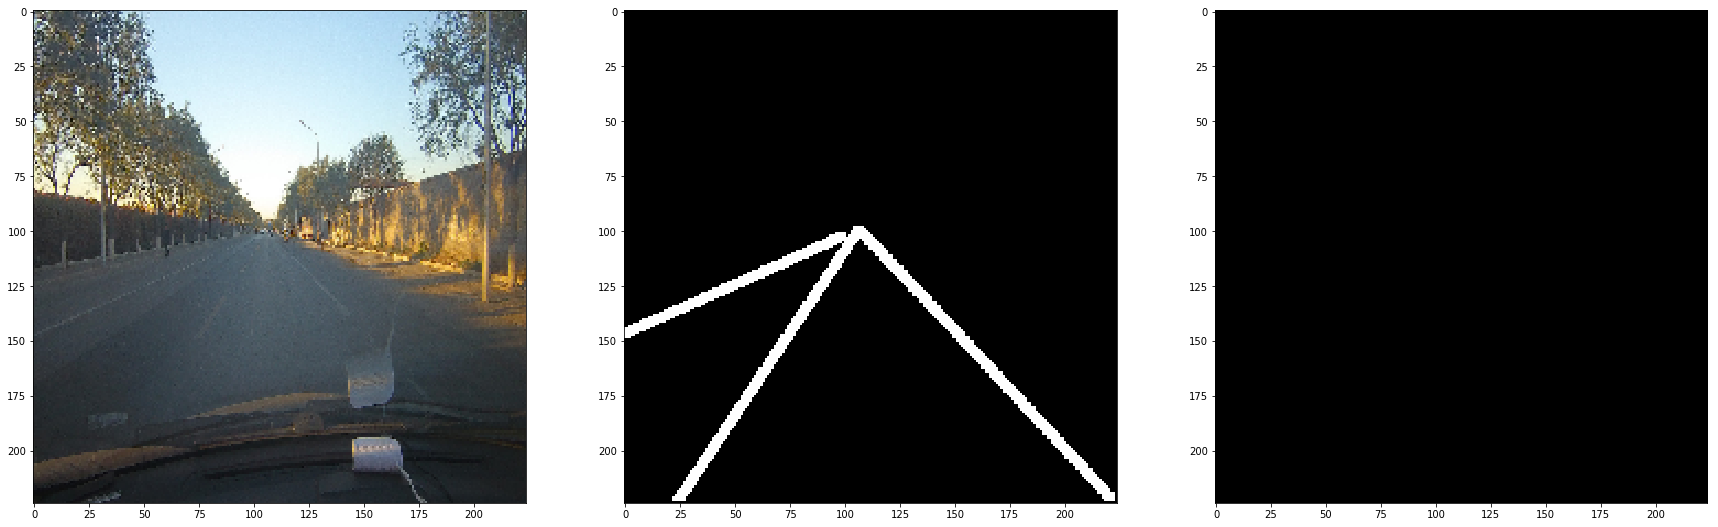

In [35]:
# show the detected points on a valid image
test_index = random.randint(0, len(val_labels))
test_label = val_labels[test_index,:,:,1]
test_img = plt.imread(val_image_paths[test_index])
test_img = cv2.resize(test_img,(DATA_SHAPE,DATA_SHAPE))
test_points = detect_points(test_img, deeplab3, DATA_SHAPE)
fig, axs = plt.subplots(1, 3, figsize=(30,30)) 
axs[0].imshow(test_img)
axs[1].imshow(test_label,cmap='gray')
axs[2].imshow(test_points,cmap='gray')
plt.show()

# Save result

In [36]:
# detect points for images set
def detect_test_list(model, shape):
    test_set_path = '/data/mc_data/MLDC/data/test0/images/' 
    test_md5_paths = open('/home/mc16/test0_list.txt','r').readlines()
    points_list = np.zeros((len(test_md5_paths), shape, shape), np.uint8)
    i = 0
    for path in tqdm(test_md5_paths):
        md5 = path.split('.')[0]
        img = plt.imread(test_set_path + md5 +'.jpg')
        points_logist = detect_points(img, model, shape)
        points_list[i] = points_logist
        i = i + 1
    return points_list

def detect_val_points(val_images, model, shape):
    points_list = np.zeros((len(val_images), shape, shape), np.uint8)
    i = 0
    for image in tqdm(val_images):
        points_list[i] = detect_points(image, model, shape)
        i = i + 1
    return points_list

In [ ]:
# save detected points for images in test0 and val
import datetime
TIMEFORMAT = '%m-%d-%H:%M:%S'
time = datetime.datetime.now().strftime(TIMEFORMAT)
test_detect_points = detect_test_list(model, DATA_SHAPE)
np.save("/home/mc16/result/test_points_%s.npy"%time, test_detect_points)
time = datetime.datetime.now().strftime(TIMEFORMAT)
val_detect_points = detect_val_points(val_images, model, DATA_SHAPE)
np.save("/home/mc16/result/val_points_%s.npy"%time, val_detect_points)